# ATLeS - Descriptive Statistics

This script is designed to provide a general purpose tool for producing descriptive statistics and visualizations for ATLES data. The idea here is that notebook will provide a basic framework for you to build from.

## Instructions
Provide experiment details in the 'Parameters' section below, then execute script to generate stats.

## General Information
Everytime an experiment is run ATLeS generates three files. 
1. date-time-experimentname.txt (log of tracking activity/issues)
2. date-time-experimentname-setup.txt (details of experimental setup)
3. date-time-experimentname-track.csv (track files; raw tracking data)

Broadly this notebook will:
1. grab the relevant data sources (see above) and intergrate them
2. clean up the data a bit
3. summarize the data a bit
4. vizualize the data a bit





# Import Libraries

In [39]:
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

# add src/ directory to path to import ATLeS code
import os
import sys
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# imported from ATLeS
from analysis.process import TrackProcessor
from analysis.plot import TrackPlotter

# displays plots in notbook output
%matplotlib inline 

## Parameters
Input experiment details here

In [40]:
experimentname = 'ACTEST2'
trackdirectory = '../data/tracks'
experimenttype = 'extinction' # set this to extinction or none, an extra set of outcomes are generataed for experiments looking at extinction of a conditioned response


Set analysis options here:

In [41]:
acquisitionlevel = .85  # sets the cut off level of excluding tracks based on poor tracking
notriggerexclude = True  # if set to True, excludes tracks where the trigger was never triggered. If set to False, includes tracks where no trigger occurred 

## Globals

In [42]:
framelist = [] # used to keep track of frames generated and combined in subsequent steps

## Identify the Data Files


In [43]:
# finds track and settingsfiles within the trackdirectory that match the experiment names
# and creates lists

trackfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*track.csv'))
settingsfiles = list(Path(trackdirectory).glob(f'**/*{experimentname}*setup.txt'))
    
print(f'{len(trackfiles)} track files were found with the name {experimentname}')
print(f'{len(settingsfiles)} settings files were found with the name {experimentname}\n')

if len(trackfiles) != len(settingsfiles):
    print('Warning: Mismatched data and settings files.')

61 track files were found with the name ACTEST2
61 settings files were found with the name ACTEST2



## Identify and Store Experimental Settings
The number of experimental phases varies across experiments. This block identifies the phases used for the current experiment and verfies that all tracks have the same phase information.
The settings may vary between tracks within an experiment. This block also identifies the settings for each track and writes them to a dictionary.

In [44]:
Config = configparser.ConfigParser()

settingsdic ={} #used to store results of this block
phaselist = [] #used later to verify phases are consistent across tracks


# reads and organizes information from each settings file
for file in settingsfiles:
    Config.read(file)
    
    # generate clean list of stimuli
    stiminfo = Config.get('experiment', 'stimulus') #gets stim info
    stiminfo = stiminfo.replace('(', ',').replace(')', '').replace(' ', '').split(',')[1:] #cleans phase list
    
    # generate clean list of phases
    phaselisttemp = Config.get('phases', 'phases_argstrings') # gets phase info
    phaselisttemp = phaselisttemp.replace('-p ', '').replace(' ', '').split(',')[:-1] #cleans phase list

    # compare each phase list with the list from the previous settings file
    if len(phaselist) == 0:
        phaselist = phaselisttemp
    elif phaselist != phaselisttemp:
        print('Warning: Inconsistent phases between settings files.')
    else:
        pass

    # counts phases and generates phase variable names
    phasenumber = len(phaselist)//2
    phasenames = []
    for i in range(phasenumber):
        p, t, s = 'phase', 'time', 'stim'
        phase = p+str(i+1)
        phasetime = phase + t
        phasestim = phase + s
        phasenames.extend((phasetime, phasestim))

    # gets settings info from file name (track/box)
    trackname = file.parts[-1].replace("-setup.txt", "")
    box = file.parts[-2]

    # gets settings info from setting file
    controller = Config.get('experiment', 'controller')
    trigger = Config.get('experiment', 'trigger')

    settings = [phaselisttemp, controller, trigger, stiminfo, box, str(file)]
    
    # puts all settings in dic keyed to trackname
    settingsdic[trackname] = settings

# creates settings dataframe from settingsdic
dfsettings = pd.DataFrame(settingsdic).transpose()
dfsettings.columns = ['phases', 'controller', 'trigger', 'stimulus', 'box', 'file']
dfsettings['track'] = dfsettings.index

# creates stimulus dataframe splits up and names stims
dfstim = pd.DataFrame(dfsettings.stimulus.values.tolist(), index=dfsettings.index).fillna('-')

for col in range(dfstim.shape[1]):
    dfstim=dfstim.rename(columns = {col:('stim_setting' + str(col))})

framelist.append(dfsettings)
dfsettings.head(3)

,phases,controller,trigger,stimulus,box,file,track
20180219-162833-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos < 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180219-162833-ACTEST2-s...,20180219-162833-ACTEST2
20180303-140323-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos < 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180303-140323-ACTEST2-s...,20180303-140323-ACTEST2
20180213-162455-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180213-162455-ACTEST2-s...,20180213-162455-ACTEST2


## Identify Phasetimes and Create Phase Dataframe

In [45]:
# Identify Phasetimes: extract phase info from settings w. trackname and calculate phasetimes
# this currently assummes all phase time are the same across tracks within the experiment
phaseinfo = settingsdic.get(trackname)[0]
phaseinfo = [x for x in phaseinfo if any(c.isdigit() for c in x)]
phaseinfo = list(map(int, phaseinfo))
phaseinfo = [i * 60 for i in phaseinfo]
phaselen = len(phaseinfo)

phaset = []
for i in range(phaselen):
    times = sum(phaseinfo[0:i+1])
    phaset.append(times)

# moves 0 to the first entry of phaset (works, but need to find a cleaner way to do this)
a = 0
phaset[0:0] = [a]

phasedic = {}
for i in range(phaselen):
    phasedic[i+1] = [phaset[i], phaset[i+1]]


# splits up and names the phases
dfphase = pd.DataFrame(dfsettings.phases.values.tolist(), index=dfsettings.index).fillna('-')
dfphase.columns = phasenames

phasenum = len(dfphase.columns)//2 # figure out what this is for.... 

framelist.append(dfphase)

dfphase.head(3)


,phase1time,phase1stim,phase2time,phase2stim,phase3time,phase3stim
20180219-162833-ACTEST2,5,off,5,on,10,off
20180303-140323-ACTEST2,5,off,5,on,10,off
20180213-162455-ACTEST2,5,off,5,on,10,off


## Generate Basic Stats

In [46]:
dfstats = pd.DataFrame()

for track in trackfiles:
    # gets track from file name
    trackname = track.parts[-1].replace("-track.csv", "")
    
    # gets stats from TrackProcessor (ATLeS analysis class)
    processor = TrackProcessor(str(track), normalize_x_with_trigger='xpos < 0.50')
    tempstatsdic = processor.get_stats(include_phases=True) # gets stats from track object
    
    # flattens dictionary into dataframe, from https://stackoverflow.com/questions/13575090/
    dftemp = pd.DataFrame.from_dict({(i,j): tempstatsdic[i][j] for i in tempstatsdic.keys() for j in tempstatsdic[i].keys()}, orient='index')
    
    #transposes dataframe and adds track as index
    dftemp = dftemp.transpose()
    dftemp['track'] = trackname 
    dftemp.set_index('track', inplace=True)
    
    dfstats = dfstats.append(dftemp, sort=True)

if 'phase 0' in dfstats.columns:
    dfstats.rename({'phase 0': 'p1', 'phase 1': 'p2', 'phase 2': 'p3'}, axis='columns', inplace = True)

dfstats.columns = dfstats.columns.map('|'.join)
    
framelist.append(dfstats)    
    
dfstats.head(3)

,all|#Datapoints,all|#Freezes,all|#Triggers,all|#Valid,all|%Valid datapoints,all|Avg. normed x coordinate,all|Avg. speed (?/sec),all|Avg. time per freeze (sec),all|Avg. time per trigger (sec),all|Avg. x coordinate,...,phase 3|Avg. x speed (?/sec),phase 3|Avg. y coordinate,phase 3|Avg. y speed (?/sec),phase 3|Freeze frequency (per min),phase 3|Total distance traveled (?),phase 3|Total time (sec),phase 3|Total time frozen (sec),phase 3|Total time triggered (sec),phase 3|Trigger frequency (per min),phase 3|Valid time (sec)
track,,,,,,,,,,,,,,,,,,,,,
20180303-140323-ACTEST2,11989.0,4.0,162.0,11978.0,0.999082,0.453400,0.211504,39.397750,2.606121,0.546600,...,0.113900,0.240247,0.053649,0.200015,81.223056,599.9547,146.8919,202.1632,5.600423,599.6567
20180219-162833-ACTEST2,11992.0,39.0,77.0,11974.0,0.998499,0.336595,0.090913,5.821121,2.409019,0.663405,...,0.048981,0.137688,0.023124,2.400172,35.668226,599.9571,119.4581,90.5968,1.600114,599.7578
20180126-162646-ACTEST2,11992.0,13.0,68.0,11982.0,0.999166,0.356098,0.057592,25.261700,6.607431,0.356098,...,0.037321,0.451903,0.029200,0.900067,31.472323,599.9556,49.3343,300.1005,2.800207,599.9556


## Generate Extinction Stats

In [47]:
if experimenttype == 'extinction':

    dfextstats = pd.DataFrame()

    for track in trackfiles:
        # gets track from file name
        trackname = track.parts[-1].replace("-track.csv", "")

        # gets advances stats from TrackProcessor (ATLeS analysis class)
        processor = TrackProcessor(str(track)) # passes track to track processor and returns track object
        tempstatsdic = processor.get_exp_stats('extinction') # gets stats from track object

        dftemp3 = pd.DataFrame(tempstatsdic, index=[0])

        dftemp3['track'] = trackname 
        dftemp3.set_index('track', inplace=True)

        dfextstats = dfextstats.append(dftemp3, sort=True)
    
    framelist.append(dfextstats)
    

else:
    print('Extinction experiment not selected in Parameters section.')


dfextstats.head(3)

,phase1-tme to 1st trigger frm phs start,phase1-tme to 1st trigger_plus1 frm phs start,phase1-tme to 1st trigger_plus2 frm phs start,phase1-tme to 1st trigger_plus3 frm phs start,phase1-tme to 1st trigger_plus4 frm phs start,phase2-tme to 1st trigger frm phs start,phase2-tme to 1st trigger frm prev trigger,phase2-tme to 1st trigger_plus1 frm phs start,phase2-tme to 1st trigger_plus1 frm prev trigger,phase2-tme to 1st trigger_plus2 frm phs start,...,phase3-tme to 1st trigger frm phs start,phase3-tme to 1st trigger frm prev trigger,phase3-tme to 1st trigger_plus1 frm phs start,phase3-tme to 1st trigger_plus1 frm prev trigger,phase3-tme to 1st trigger_plus2 frm phs start,phase3-tme to 1st trigger_plus2 frm prev trigger,phase3-tme to 1st trigger_plus3 frm phs start,phase3-tme to 1st trigger_plus3 frm prev trigger,phase3-tme to 1st trigger_plus4 frm phs start,phase3-tme to 1st trigger_plus4 frm prev trigger
track,,,,,,,,,,,,,,,,,,,,,
20180303-140323-ACTEST2,0.0048,0.0048,1.2063,1.2063,10.1036,206.9687,223.7824,207.3683,224.1820,207.8689,...,0.0399,0.1000,0.0399,0.1000,0.0399,0.1,NaN,NaN,NaN,NaN
20180219-162833-ACTEST2,0.0072,0.0072,1.6063,1.7044,1.8050,84.3770,370.1737,84.5793,370.3760,86.5792,...,0.0454,0.1041,0.0454,0.1041,NaN,NaN,NaN,NaN,NaN,NaN
20180126-162646-ACTEST2,0.0042,0.0042,0.7058,0.7058,0.8039,148.4718,438.3684,149.0718,438.9684,149.5718,...,0.0393,0.0999,0.0393,0.0999,NaN,NaN,NaN,NaN,NaN,NaN


## Combine Dataframes
Combines settings, stim, phase, and with dataframe of basic descriptive stats.


In [48]:
df = pd.concat(framelist, axis=1, sort=False) # combines all frames
df.dropna(axis=0, how='all', inplace=True) # drops any rows where all values are missing
df.head(3)

,phases,controller,trigger,stimulus,box,file,track,phase1time,phase1stim,phase2time,...,phase3-tme to 1st trigger frm phs start,phase3-tme to 1st trigger frm prev trigger,phase3-tme to 1st trigger_plus1 frm phs start,phase3-tme to 1st trigger_plus1 frm prev trigger,phase3-tme to 1st trigger_plus2 frm phs start,phase3-tme to 1st trigger_plus2 frm prev trigger,phase3-tme to 1st trigger_plus3 frm phs start,phase3-tme to 1st trigger_plus3 frm prev trigger,phase3-tme to 1st trigger_plus4 frm phs start,phase3-tme to 1st trigger_plus4 frm prev trigger
20180219-162833-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos < 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180219-162833-ACTEST2-s...,20180219-162833-ACTEST2,5,off,5,...,0.0454,0.1041,0.0454,0.1041,NaN,NaN,NaN,NaN,NaN,NaN
20180303-140323-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos < 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180303-140323-ACTEST2-s...,20180303-140323-ACTEST2,5,off,5,...,0.0399,0.1000,0.0399,0.1000,0.0399,0.1,NaN,NaN,NaN,NaN
20180213-162455-ACTEST2,"[5, off, 5, on, 10, off]",controllers.FixedRatioController(response_step=1),xpos > 0.50,"[ac_freq_Hz=20, active_freq_Hz=1, duty_cycle=0...",bbox3,../data/tracks/bbox3/20180213-162455-ACTEST2-s...,20180213-162455-ACTEST2,5,off,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning: Dataframe Characteristics

In [49]:
print(f'Dataframe Shape:{df.shape}')
print()   

print('Column Names by DataType')
for dt in df.dtypes.unique():
    print(f'Data Type, {dt}:')
    print(*list(df.select_dtypes(include=[dt]).columns), sep = ', ')
    print()

# print('Number of Tracks with Null Data by Column:')  #fix this
# print(df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]].count())
# print()



Dataframe Shape:(61, 118)

Column Names by DataType
Data Type, object:
phases, controller, trigger, stimulus, box, file, track, phase1time, phase1stim, phase2time, phase2stim, phase3time, phase3stim

Data Type, float64:
all|#Datapoints, all|#Freezes, all|#Triggers, all|#Valid, all|%Valid datapoints, all|Avg. normed x coordinate, all|Avg. speed (?/sec), all|Avg. time per freeze (sec), all|Avg. time per trigger (sec), all|Avg. x coordinate, all|Avg. x speed (?/sec), all|Avg. y coordinate, all|Avg. y speed (?/sec), all|Freeze frequency (per min), all|Total distance traveled (?), all|Total time (sec), all|Total time frozen (sec), all|Total time triggered (sec), all|Trigger frequency (per min), all|Valid time (sec), phase 1|#Datapoints, phase 1|#Freezes, phase 1|#Triggers, phase 1|#Valid, phase 1|%Valid datapoints, phase 1|Avg. normed x coordinate, phase 1|Avg. speed (?/sec), phase 1|Avg. time per freeze (sec), phase 1|Avg. time per trigger (sec), phase 1|Avg. x coordinate, phase 1|Avg. x s

## Cleaning: Early Termination Check


Track Times: Mean 1160.2349475409835, Minimum 15.408500000000002, Maximum 1199.0315, Count 61


/share/apps/jhub/lib64/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


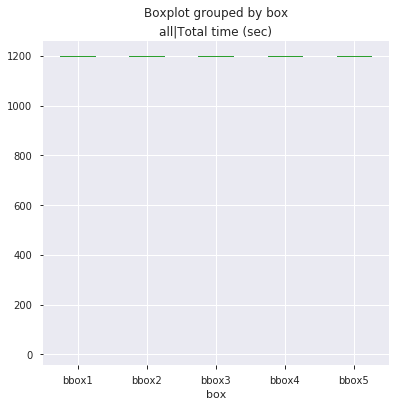

In [50]:
print(f'''Track Times: Mean {df['all|Total time (sec)'].mean()}, Minimum {df['all|Total time (sec)'].min()}, Maximum {df['all|Total time (sec)'].max()}, Count {df['all|Total time (sec)'].count()}''')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.ticklabel_format(useOffset=False) # prevents appearance of scientific notation on y axis
df.boxplot(column='all|Total time (sec)', by='box', ax=ax)

## Cleaning: Poor Tracking Check


Valid Datapoints: Mean 0.9755440048521484, Minimum 0.19087725150100066, Maximum 1.0, Count 61


/share/apps/jhub/lib64/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


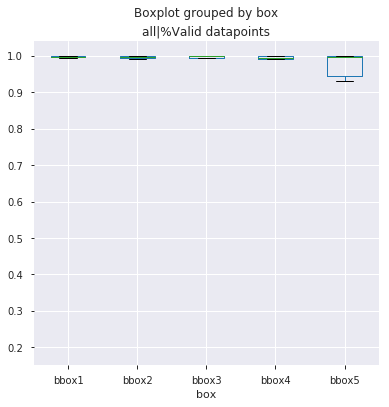

In [51]:
print(f'''Valid Datapoints: Mean {df['all|%Valid datapoints'].mean()}, Minimum {df['all|%Valid datapoints'].min()}, Maximum {df['all|%Valid datapoints'].max()}, Count {df['all|%Valid datapoints'].count()}''')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='all|%Valid datapoints', by='box', ax=ax)

## Cleaning: No Trigger Check


Number of Triggers: Mean 10.310344827586206, Minimum 1.0, Maximum 192.0, Count 61


/share/apps/jhub/lib64/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


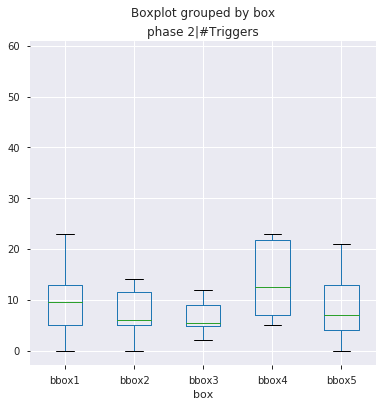

In [52]:
print(f'''Number of Triggers: Mean {df['phase 2|#Triggers'].mean()}, Minimum {df['all|#Triggers'].min()}, Maximum {df['all|#Triggers'].max()}, Count {df['all|#Triggers'].count()}''')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='phase 2|#Triggers', by='box', ax=ax)

## Cleaning: Removing Tracks for Early Termination, Poor Tracking, No Trigger


Raw Track Number: 52
Modified Track Number: 52 (following removal of tracks less than 75% the length of the experiment mean)
Modified Track Number: 52 (following removal for poor tracking set at less than 0.85% valid datapoints)
Modified Track Number: 52 (following removal of tracks with no triggers during the learning)


/share/apps/jhub/lib64/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


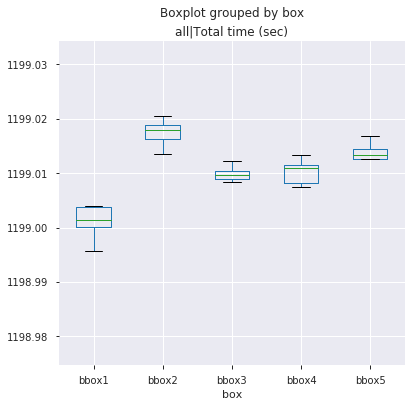

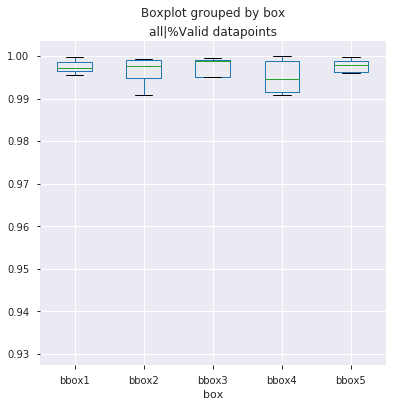

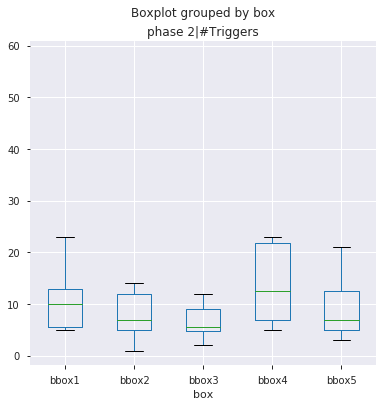

In [59]:
print(f'Raw Track Number: {df.shape[0]}')

df = df.drop(df[df['all|Total time (sec)'] < (df['all|Total time (sec)'].mean())* .75].index) # drops rows if any data is missing, this will remove early termination tracks
print(f'Modified Track Number: {df.shape[0]} (following removal of tracks less than 75% the length of the experiment mean)')

df = df.drop(df[df['all|%Valid datapoints'] < acquisitionlevel].index)
print(f'Modified Track Number: {df.shape[0]} (following removal for poor tracking set at less than {acquisitionlevel}% valid datapoints)')

if notriggerexclude == True:
    df = df.drop(df[df['phase 2|#Triggers'] == 0].index) # drops rows if there was no trigger during phase 2; NOTE: fix this so it works if learning phase in not 2
    print(f'Modified Track Number: {df.shape[0]} (following removal of tracks with no triggers during the learning)')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.ticklabel_format(useOffset=False) # prevents appearance of scientific notation on y axis
df.boxplot(column='all|Total time (sec)', by='box', ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='all|%Valid datapoints', by='box', ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='phase 2|#Triggers', by='box', ax=ax)    

## Cleaning: Checking Randomization of Trigger Condition

In [14]:
print(f'Trigger Conditions: {df.trigger.unique()}')
print()

from scipy.stats import ttest_ind

# performs welch's t-test (does not assume equal variances) on all floats and prints any that are signficantly different as a function of trigger
for i in df.select_dtypes(include=['float64']).columns:
    ttest_result = ttest_ind(df[df.trigger == df.trigger.unique()[0]][i], df[df.trigger == df.trigger.unique()[1]][i], equal_var=False, nan_policy='omit')
    
    if ttest_result.pvalue < .05:
        print(f'Welchs T-Test shows {i} is significantly different as a function of trigger condition, p = {ttest_result.pvalue}')
        print(f'{i} Trigger Condition 1 Mean: {df[df.trigger == df.trigger.unique()[0]][i].mean()}')
        print(f'{i} Trigger Condition 2 Mean: {df[df.trigger == df.trigger.unique()[1]][i].mean()}')
        print()

Trigger Conditions: ['xpos < 0.50' 'xpos > 0.50']

Welchs T-Test shows all|Avg. x coordinate is significantly different as a function of trigger condition, p = 5.758621024223611e-13
all|Avg. x coordinate Trigger Condition 1 Mean: 0.6323015952527328
all|Avg. x coordinate Trigger Condition 2 Mean: 0.38316624116367126

Welchs T-Test shows phase 1|#Valid is significantly different as a function of trigger condition, p = 0.02924188262768202
phase 1|#Valid Trigger Condition 1 Mean: 2979.6296296296296
phase 1|#Valid Trigger Condition 2 Mean: 2987.344827586207

Welchs T-Test shows phase 1|%Valid datapoints is significantly different as a function of trigger condition, p = 0.02100518592287032
phase 1|%Valid datapoints Trigger Condition 1 Mean: 0.9965935172209546
phase 1|%Valid datapoints Trigger Condition 2 Mean: 0.9993190997445439

Welchs T-Test shows phase 1|Valid time (sec) is significantly different as a function of trigger condition, p = 0.027084877014018894
phase 1|Valid time (sec) Trigge

## Cleaning: Checking for Box Variations
to do (ANOVA?) 

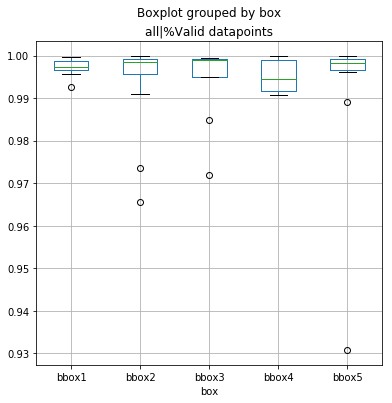

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='all|%Valid datapoints', by='box', ax=ax)

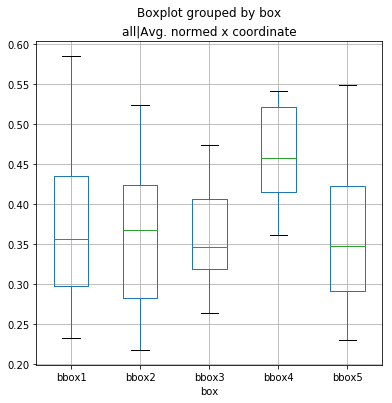

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
df.boxplot(column='all|Avg. normed x coordinate', by='box', ax=ax)

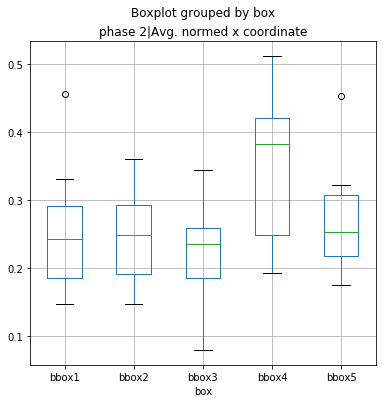

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
df.boxplot(column='phase 2|Avg. normed x coordinate', by='box', ax=ax)

## Basic Descriptives

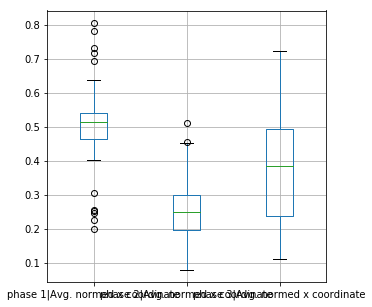

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
df.boxplot(column=['phase 1|Avg. normed x coordinate', 'phase 2|Avg. normed x coordinate', 'phase 3|Avg. normed x coordinate'], ax=ax)

/share/apps/jhub/lib64/python3.6/site-packages/pandas/plotting/_core.py:2257: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  return_type=return_type, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2b3d89b4c128>,
      dtype=object)

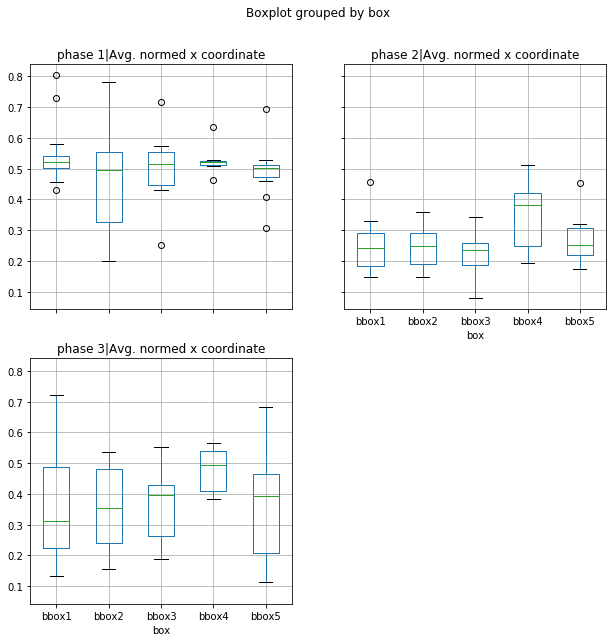

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
 
df.boxplot(column=['phase 1|Avg. normed x coordinate', 'phase 2|Avg. normed x coordinate', 'phase 3|Avg. normed x coordinate'], by='box', ax=ax)

## Analysis/Viz

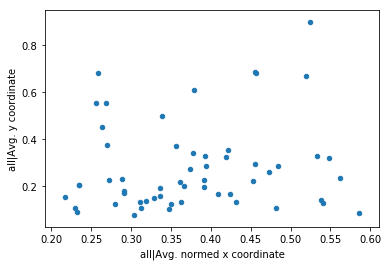

In [20]:
df.plot(kind="scatter", x=('all|Avg. normed x coordinate'), y=('all|Avg. y coordinate'))

/share/apps/jhub/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


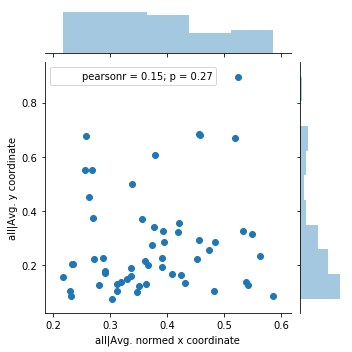

In [21]:
seaborn.jointplot(x=('all|Avg. normed x coordinate'), y=('all|Avg. y coordinate'), data=df, size=5)

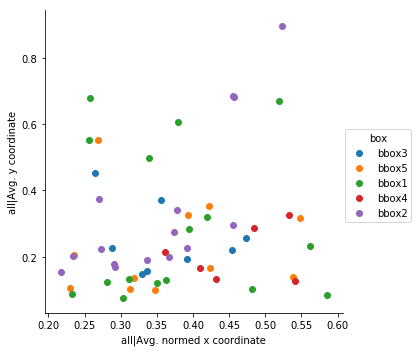

In [22]:
seaborn.FacetGrid(df, hue="box", size=5) \
   .map(plt.scatter, ('all|Avg. normed x coordinate'), ('all|Avg. y coordinate')) \
   .add_legend()

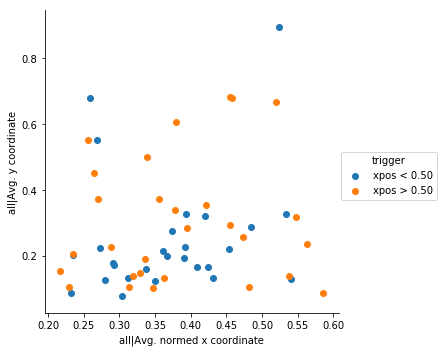

In [23]:
seaborn.FacetGrid(df, hue="trigger", size=5) \
   .map(plt.scatter, ('all|Avg. normed x coordinate'), ('all|Avg. y coordinate')) \
   .add_legend()

## Viz: Heatmaps Per Phase

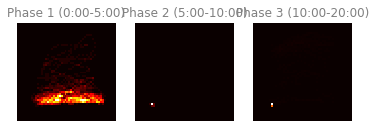

In [24]:
plotter = TrackPlotter(processor)
plotter.plot_heatmap(plot_type='per-phase')

In [ ]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df.loc[:, df.columns.str.contains('all')])
